In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import random
import seaborn as sns
import optuna
from torch.utils.data import DataLoader, Dataset, TensorDataset, SequentialSampler
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from torch.cuda import amp
from optuna.samplers import TPESampler

2025-06-05 21:40:33.391655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749159633.586719      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749159633.639572      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Config:
    SEED = 42
    MAX_LEN = 256
    BATCH_SIZE = 16
    LEARNING_RATE = 1.827226177606625e-05
    EPOCHS = 2
    WARMUP_PROPORTION = 0.1799264218662403
    GRADIENT_ACCUMULATION_STEPS = 2
    EARLY_STOPPING_PATIENCE = 2
    MODEL_NAME = 'distilbert-base-uncased'
    WEIGHT_DECAY = 0.02404167763981929
    DROPOUT = 0.1467983561008608

# ✅ Set seed for reproducibility
def set_seed(seed=Config.SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [ ]:
# Files checking
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/sample_submission.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/train_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/test_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/val_dataset.csv


In [ ]:
train_df = pd.read_csv(os.path.join('../input', 'train_dataset.csv'))
test_df = pd.read_csv(os.path.join('../input', 'test_dataset.csv'))
val_df = pd.read_csv(os.path.join('../input', 'val_dataset.csv'))

# Check column names
print(f"Train columns: {train_df.columns}")
print(f"Test columns: {test_df.columns}")

Train columns: Index(['ID', 'Text', 'Label'], dtype='object')
Test columns: Index(['ID', 'Text'], dtype='object')


Class weights: [1.00002696 0.99997304]


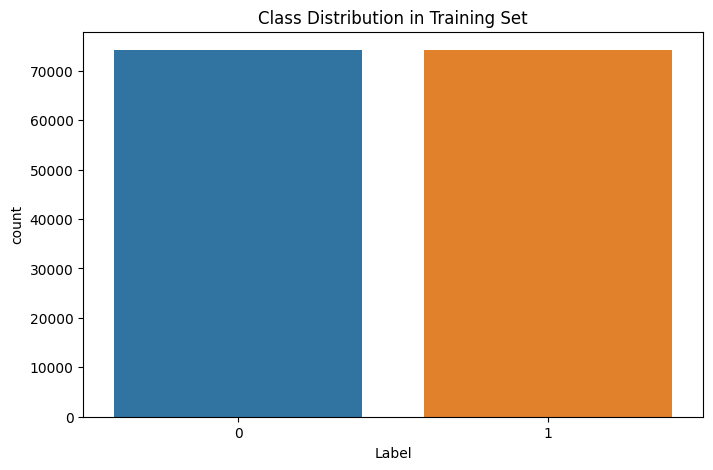

In [5]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_df['Label'])
weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class weights: {class_weights}")

# Plot class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Label', data=train_df)
plt.title('Class Distribution in Training Set')
plt.show()

In [6]:
# 🧹 Preprocessing
tokenizer = DistilBertTokenizer.from_pretrained(Config.MODEL_NAME)

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoded['input_ids'].flatten(),
            'attention_mask': encoded['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
# # OPTUNA
# # ======================================================
# # 🎛️ Optuna Hyperparameter Optimization for DistilBERT
# # ======================================================
# def objective(trial):
#     # Suggested hyperparameters
#     params = {
#         'lr': trial.suggest_float('lr', 1e-5, 5e-5, log=True),
#         'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
#         'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.1),
#         'dropout': trial.suggest_float('dropout', 0.1, 0.4),
#         'epochs': trial.suggest_int('epochs', 2, 5),
#         'warmup_ratio': trial.suggest_float('warmup_ratio', 0.05, 0.2),
#         'max_len': trial.suggest_categorical('max_len', [64, 128, 160, 256])
#     }
    
#     # Initialize device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Initialize tokenizer
#     tokenizer = DistilBertTokenizer.from_pretrained(Config.MODEL_NAME)
    
#     # Create datasets with dynamic max_len
#     train_dataset = TweetDataset(train_df['Text'], train_df['Label'], tokenizer, params['max_len'])
#     val_dataset = TweetDataset(val_df['Text'], val_df['Label'], tokenizer, params['max_len'])
    
#     # Create data loaders
#     train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=params['batch_size']*2)
    
#     # Initialize model with suggested dropout
#     model = DistilBertForSequenceClassification.from_pretrained(
#         Config.MODEL_NAME,
#         num_labels=2,
#         dropout=params['dropout']
#     ).to(device)
    
#     # Configure loss function
#     loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    
#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), 
#                      lr=params['lr'],
#                      weight_decay=params['weight_decay'])

#     # Calculate total steps
#     total_steps = len(train_loader) * params['epochs']
    
#     # Configure scheduler
#     scheduler = get_linear_schedule_with_warmup(
#         optimizer,
#         num_warmup_steps=int(total_steps * params['warmup_ratio']),
#         num_training_steps=total_steps
#     )
    
#     # Training loop
#     best_val_loss = float('inf')
#     for epoch in range(params['epochs']):
#         # Training
#         model.train()
#         total_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
            
#             inputs = {
#                 'input_ids': batch['input_ids'].to(device),
#                 'attention_mask': batch['attention_mask'].to(device),
#                 'labels': batch['label'].to(device)
#             }
            
#             outputs = model(**inputs)
#             loss = outputs.loss
#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             total_loss += loss.item()
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 inputs = {
#                     'input_ids': batch['input_ids'].to(device),
#                     'attention_mask': batch['attention_mask'].to(device),
#                     'labels': batch['label'].to(device)
#                 }
#                 outputs = model(**inputs)
#                 val_loss += outputs.loss.item()
        
#         avg_val_loss = val_loss / len(val_loader)
#         trial.report(avg_val_loss, epoch)
        
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()
            
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
    
#     return best_val_loss

# def run_optuna_study():
#     study = optuna.create_study(
#         direction='minimize',
#         sampler=TPESampler(seed=Config.SEED)
#     )
#     study.optimize(objective, n_trials=5)  # Start with 5 trials
    
#     print("Best trial:")
#     trial = study.best_trial
#     print(f"Validation Loss: {trial.value:.4f}")
#     print("Best Params:")
#     for key, value in trial.params.items():
#         print(f"{key:15}: {value}")
    
#     return study

# # ======================================================
# # 🔍 Run Optuna Study (Uncomment to run)
# # ======================================================
# study = run_optuna_study()
# best_params = study.best_trial.params

# # Update Config with best parameters
# Config.BATCH_SIZE = best_params['batch_size']
# Config.LEARNING_RATE = best_params['lr']
# Config.WEIGHT_DECAY = best_params['weight_decay']
# Config.EPOCHS = best_params['epochs']
# Config.WARMUP_PROPORTION = best_params['warmup_ratio']
# Config.MAX_LEN = best_params['max_len']
# Config.DROPOUT = best_params['dropout']

# # ======================================================
# # Proceed with your original training code below
# # ======================================================

# print("SEED:", Config.SEED)
# print("MAX_LEN:", Config.MAX_LEN)
# print("BATCH_SIZE:", Config.BATCH_SIZE)
# print("LEARNING_RATE:", Config.LEARNING_RATE)
# print("EPOCHS:", Config.EPOCHS)
# print("WARMUP_PROPORTION:", Config.WARMUP_PROPORTION)
# print("GRADIENT_ACCUMULATION_STEPS:", Config.GRADIENT_ACCUMULATION_STEPS)
# print("EARLY_STOPPING_PATIENCE:", Config.EARLY_STOPPING_PATIENCE)
# print("MODEL_NAME:", Config.MODEL_NAME)
# print("WEIGHT_DECAY:", Config.WEIGHT_DECAY)
# print("DROPOUT:", Config.DROPOUT)

In [8]:
# ✅ Dataloaders
train_dataset = TweetDataset(train_df['Text'], train_df['Label'], tokenizer, Config.MAX_LEN)
val_dataset = TweetDataset(val_df['Text'], val_df['Label'], tokenizer, Config.MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

In [9]:
# 🧠 Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Pass to model
model = DistilBertForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=2,
    dropout=Config.DROPOUT
)

loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(device))
model.config.class_weight = weights.to(device)  

# ⚙️ Device setup
model.to(device)

Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1467983561008608, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.146

In [10]:
# ⚙️ Optimizer
optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE, eps=1e-8, weight_decay=Config.WEIGHT_DECAY)

In [11]:
# ⏳ Scheduler setup
total_steps = len(train_loader) * Config.EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(Config.WARMUP_PROPORTION * total_steps),
    num_training_steps=total_steps
)

# Mixed precision training
scaler = torch.amp.GradScaler()

In [12]:
# 🕒 Format time helper
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [13]:
# 🔁 Training loop
def train_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    t0 = time.time()
    
    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        with amp.autocast():
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss_fct = torch.nn.CrossEntropyLoss(weight=model.config.class_weight)
            loss = loss_fct(outputs.logits, b_labels) / Config.GRADIENT_ACCUMULATION_STEPS
        
        scaler.scale(loss).backward()
        total_loss += loss.item() * Config.GRADIENT_ACCUMULATION_STEPS
        
        if (step + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

    avg_loss = total_loss / len(dataloader)
    training_time = format_time(time.time() - t0)
    return avg_loss, training_time

In [14]:
# 🎯 Evaluation loop
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    total_loss = 0
    t0 = time.time()

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['label'].to(device)

            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            true_labels += b_labels.cpu().tolist()

    acc = accuracy_score(true_labels, preds)
    prec, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='binary')
    avg_loss = total_loss / len(dataloader)
    validation_time = format_time(time.time() - t0)

    return acc, prec, recall, f1, avg_loss, validation_time, preds

In [15]:
# 🚀 Run training
training_stats = [] # 📈 Track training stats
best_val_loss = float('inf')
trigger_times = 0
best_model_path = 'best_model.pt'

total_t0 = time.time()

for epoch in range(Config.EPOCHS):
    print(f"\n======== Epoch {epoch + 1} / {Config.EPOCHS} ========")

    train_loss, train_time = train_epoch(model, train_loader, optimizer, scheduler)
    acc, prec, recall, f1, val_loss, val_time, _ = evaluate(model, val_loader)

    print(f"\n✅ Train Loss: {train_loss:.4f} | ⏱️ Time: {train_time}")
    print(f"✅ Val   Loss: {val_loss:.4f} | ⏱️ Time: {val_time}")
    print(f"📊 Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("💾 Saved best model!")
    else:
        trigger_times += 1
        if trigger_times >= Config.EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered!")
            break

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': train_loss,
        'Validation Loss': val_loss,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': recall,
        'F1 Score': f1,
        'Training Time': train_time,
        'Validation Time': val_time
    })

print("\nTraining complete!")
print(f"Total training took: {format_time(time.time() - total_t0)}")

# Load best model
model.load_state_dict(torch.load(best_model_path))


======== Epoch 1 / 2 ========


Training:   0%|          | 0/9275 [00:00<?, ?it/s]/tmp/ipykernel_19/4254156469.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training: 100%|██████████| 9275/9275 [28:36<00:00,  5.40it/s]



✅ Train Loss: 0.4514 | ⏱️ Time: 0:28:37
✅ Val   Loss: 0.3759 | ⏱️ Time: 0:02:47
📊 Acc: 0.8318 | Prec: 0.8245 | Recall: 0.8430 | F1: 0.8336
💾 Saved best model!

======== Epoch 2 / 2 ========


Training:   0%|          | 0/9275 [00:00<?, ?it/s]/tmp/ipykernel_19/4254156469.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training: 100%|██████████| 9275/9275 [28:39<00:00,  5.39it/s]



✅ Train Loss: 0.3616 | ⏱️ Time: 0:28:40
✅ Val   Loss: 0.3564 | ⏱️ Time: 0:02:47
📊 Acc: 0.8434 | Prec: 0.8468 | Recall: 0.8385 | F1: 0.8426
💾 Saved best model!

Training complete!
Total training took: 1:02:52


<All keys matched successfully>

In [16]:
# 📊 Display training stats as a table
df_stats = pd.DataFrame(training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Training Time,Validation Time
epoch,,,,,,,,
1,0.451386,0.375871,0.831777,0.824528,0.842964,0.833644,0:28:37,0:02:47
2,0.361614,0.356359,0.843358,0.846751,0.838483,0.842597,0:28:40,0:02:47


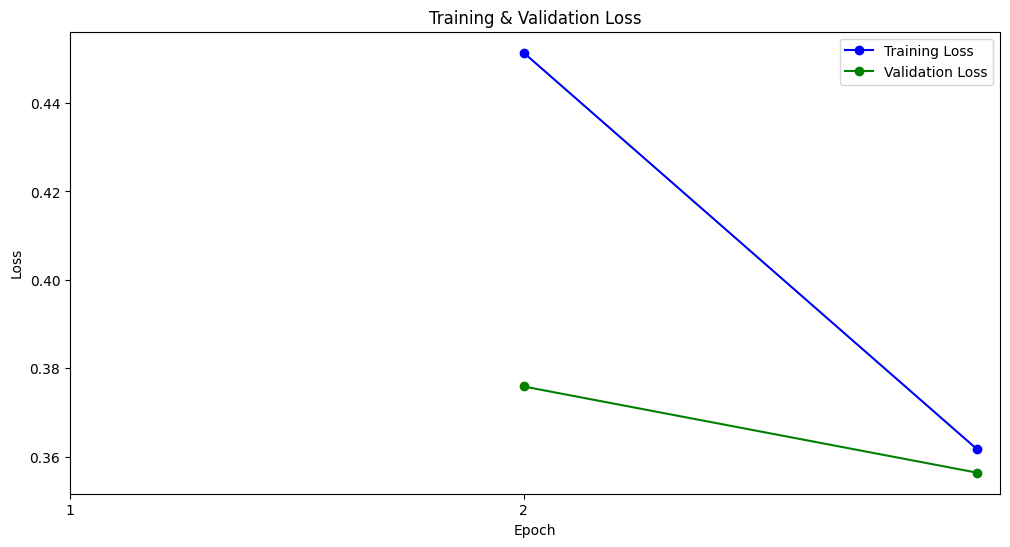

In [17]:
# 📉 Plot training & validation loss
plt.figure(figsize=(12,6))
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(len(df_stats)), df_stats.index)
plt.show()

In [18]:
# 🧪 Create test DataLoader (no labels)
test_dataset = TweetDataset(test_df['Text'], pd.Series([0]*len(test_df)), tokenizer, Config.MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

In [19]:
# 🔍 Predict
model.eval()
all_preds = []

print(f'🔮 Predicting sentiment for {len(test_df)} tweets...')

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

print("✅ Prediction complete.")

🔮 Predicting sentiment for 21199 tweets...


Predicting: 100%|██████████| 1325/1325 [01:24<00:00, 15.64it/s]

✅ Prediction complete.


In [20]:
# 📤 Save predictions with IDs
submission_df = pd.DataFrame({'ID': test_df['ID'],'Predicted': all_preds})
submission_df.to_csv("submission.csv", index=False)
print("📁 Submission file saved as 'submission.csv'")

# Show sample
display(submission_df.head())

📁 Submission file saved as 'submission.csv'


,ID,Predicted
0,102388,0
1,153802,0
2,61831,0
3,18317,1
4,50061,1
